# CreditCardApproval EDA Diana Max

## Setup notebook & fetch data

In [171]:
from ucimlrepo import fetch_ucirepo
#from ydata_profiling import ProfileReport

import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.contingency import association
from scipy.stats import pointbiserialr, pearsonr, spearmanr

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, FunctionTransformer, LabelBinarizer, label_binarize, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
credit_approval = fetch_ucirepo(id=27)

X = credit_approval.data.features
y = credit_approval.data.targets
df = credit_approval.data.original

## first look

In [ ]:
credit_approval.data.original

In [ ]:
ProfileReport(df)

## Univariate

### A1

[Text(0, 0.5, 'value count')]

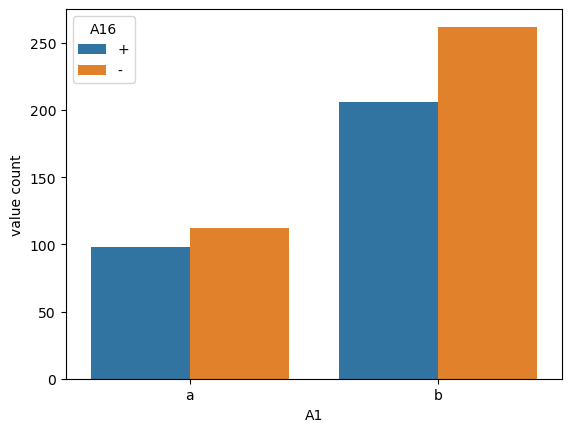

In [24]:
A1 = df[['A1','A16']]

ax = sns.barplot(
    data=A1.reset_index().groupby(['A1','A16']).count().reset_index(),
    x='A1',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Impute missing values with most frequent category.

### A2

<Axes: xlabel='A2', ylabel='Density'>

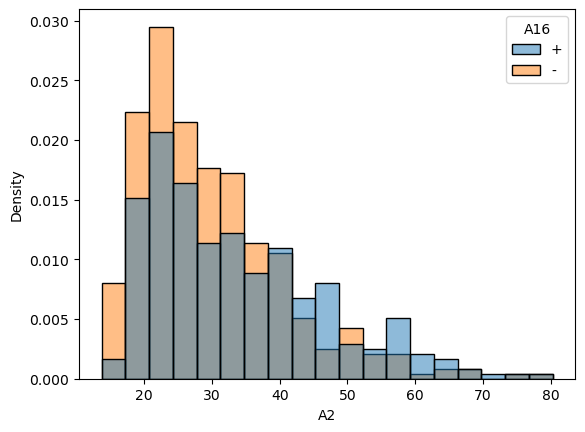

In [25]:
A2 = df[['A2','A16']]
sns.histplot(A2, x='A2', hue='A16',stat='density')

Let's try a log1p transform.

<Axes: xlabel='A2', ylabel='Density'>

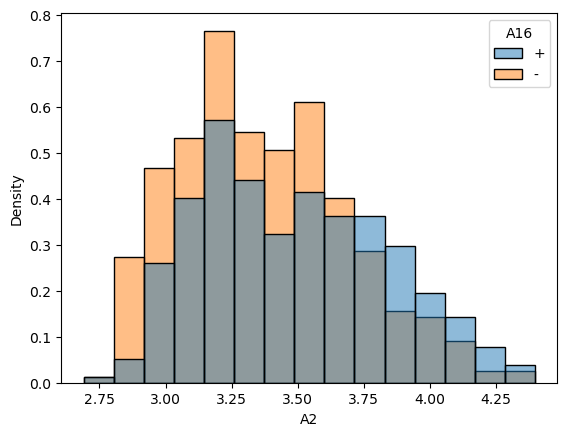

In [26]:
A2 = A2.assign(A2=A2.A2.apply(np.log1p))
sns.histplot(A2, x='A2', hue='A16',stat='density')

The distribution is less skewed now, so it seems like a usefull transformation.

Its still skewed, so impute missing values with median.

### A3

<Axes: xlabel='A3', ylabel='Density'>

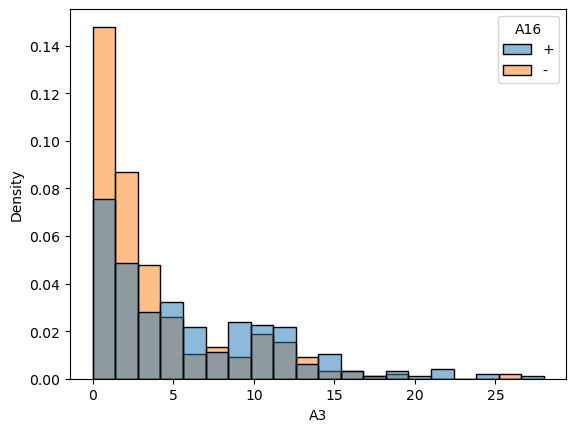

In [27]:
A3 = df[['A3','A16']]
sns.histplot(A3, x='A3', hue='A16',stat='density')

Let's try a log1p transform.

<Axes: xlabel='A3', ylabel='Density'>

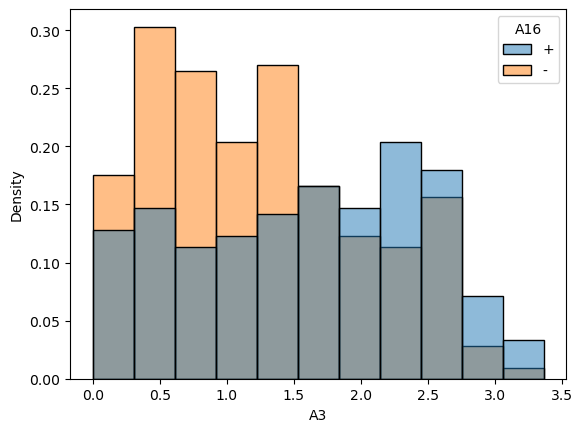

In [28]:
A3 = A3.assign(A3=A3.A3.apply(np.log1p))
sns.histplot(A3, x='A3', hue='A16',stat='density')

The distribution is much less skewed now. Looks like a very good option.

Its still skewed, so impute missing values with median.

### A4

[Text(0, 0.5, 'value count')]

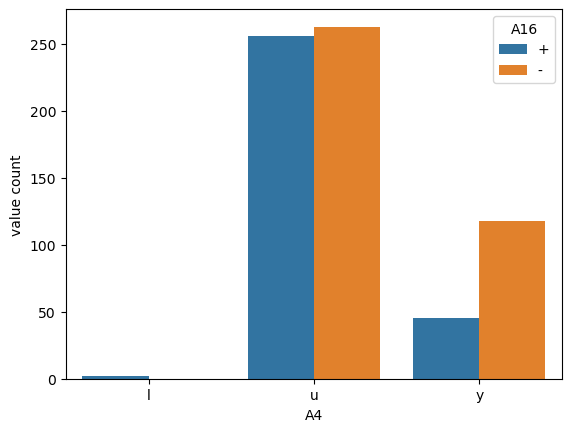

In [29]:
A4 = df[['A4','A16']]

ax = sns.barplot(
    data=A4.reset_index().groupby(['A4','A16']).count().reset_index(),
    x='A4',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Bin categories to u and non-u.

Replace missing values with the most-frequent category.

### A5

[Text(0, 0.5, 'value count')]

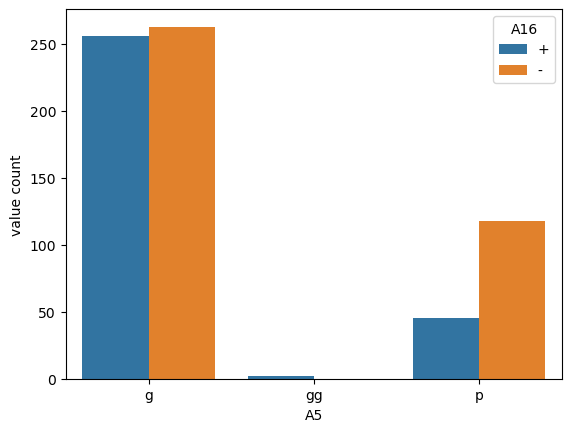

In [30]:
A5 = df[['A5','A16']]

ax = sns.barplot(
    data=A5.reset_index().groupby(['A5','A16']).count().reset_index(),
    x='A5',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Bin categories to g and non-g.

Replace missing values with the most-frequent category.

### A6

[Text(0, 0.5, 'value count')]

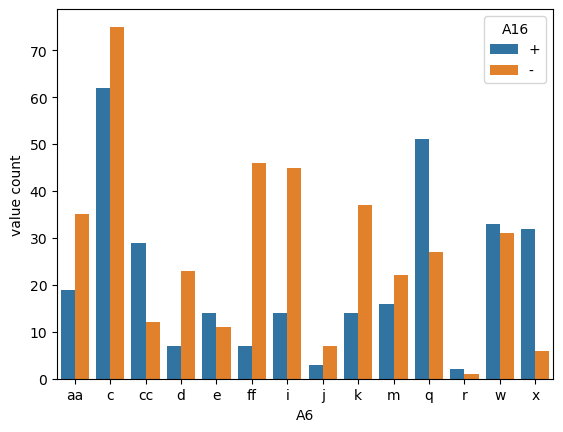

In [31]:
ax = sns.barplot(
    data=df.reset_index().groupby(['A6','A16']).count().reset_index(),
    x='A6',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Many categories with quite a range of different distributions of A16 (target) values. Target encoding seems like a reasonable choice.

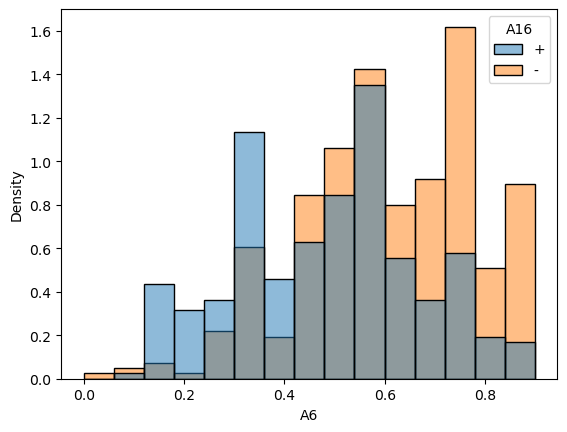

In [32]:
ax = sns.histplot(
    data= pd.DataFrame({
        'A6': TargetEncoder().fit_transform(df.A6.values[:,np.newaxis], df.A16).ravel(),
        'A16': df.A16.values}),
    x='A6',
    hue='A16',
    stat='density'
)

Target encoding looks promising.

Impute with median.

### A7

[Text(0, 0.5, 'value count')]

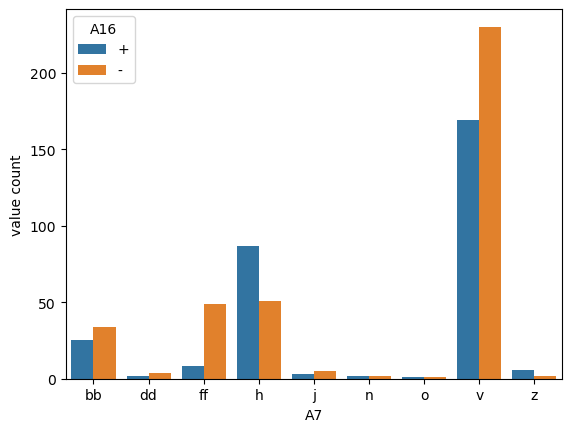

In [33]:
ax = sns.barplot(
    data=df.reset_index().groupby(['A7','A16']).count().reset_index(),
    x='A7',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Naively try target encoding first.

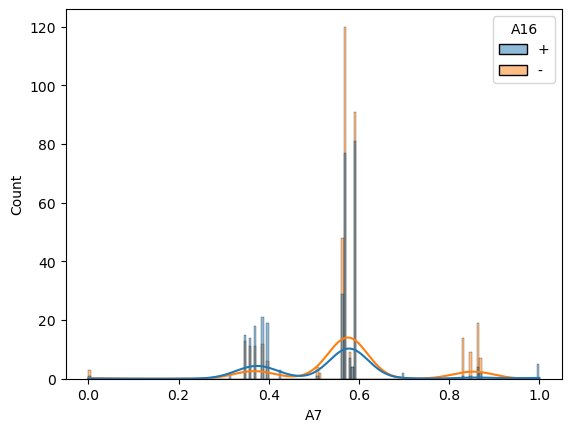

In [34]:
ax = sns.histplot(
    data= pd.DataFrame({
        'A7': TargetEncoder().fit_transform(df.A7.values[:,np.newaxis], df.A16).ravel(),
        'A16': df.A16.values}),
    x='A7',
    hue='A16',
    kde=True
)

This looks not quite usefull yet, as the kernel density estimates show curves of almost the same shape and location.

Many categories with almost no values. Summarising those categories, that have similar distributions of A16, so: (v, dd, j), (h, z), (bb, n, o), (ff), could be an option.

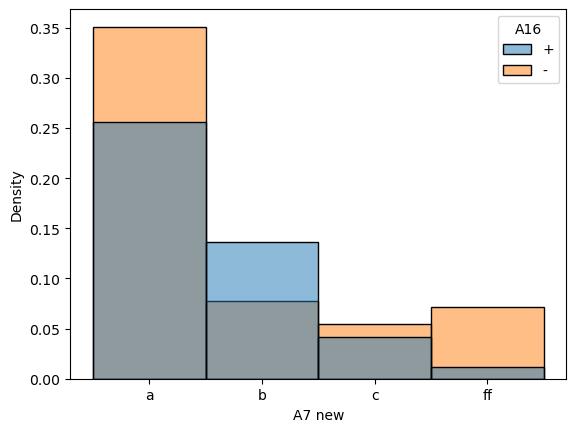

In [35]:
ax = sns.histplot(
    data=pd.DataFrame({
        'A7 new': df.A7.replace({'v':'a','dd':'a','j':'a',  'h':'b','z':'b', 'bb':'c','n':'c','o':'c'}).ravel(),
        'A16': df.A16.values}),
    x='A7 new',
    hue='A16',
    stat='density'
)

This still doesnt look very usefull, suggesting either the features is generally bad (at least for a linear classifier) or the new categories are bad.

We will come back to this feature later on. We will have a look at correlations and mutual information first to get a little more information about this feature. If it contians high information, OneHot encoding might be worth it (as it adds dimensions but this might be worth for a good feature).


Otherwise we might try other binnings of categories or throw the feature out all toghether.

### A8

<Axes: xlabel='A8', ylabel='Density'>

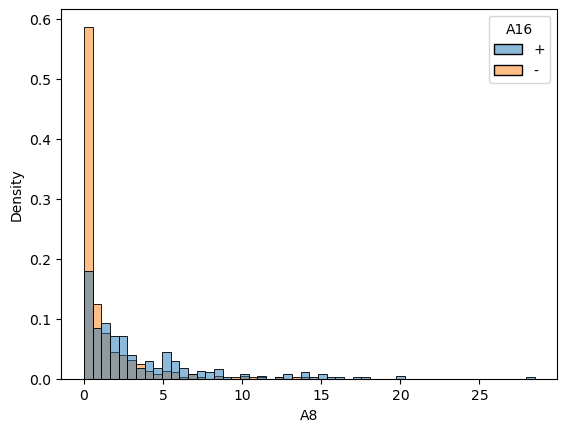

In [36]:
A8 = df[['A8','A16']]
sns.histplot(A8, x='A8', hue='A16',stat='density')

Try a log1p transform.

<Axes: xlabel='A8', ylabel='Density'>

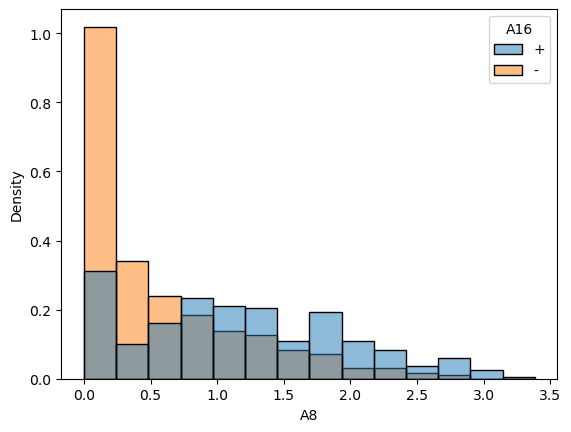

In [37]:
A8 = A8.assign(A8=A8.A8.apply(np.log1p))
sns.histplot(A8, x='A8', hue='A16',stat='density')

Although this already looks quite promising a common logarithm (base = 10) might be even better, as the distribution is still strongly left skewed.

<Axes: xlabel='A8', ylabel='Density'>

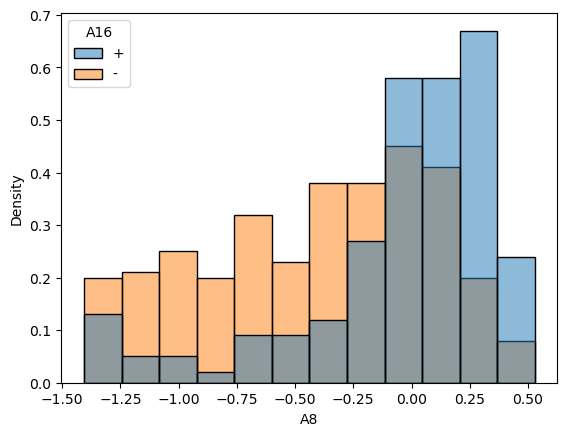

In [38]:
A8 = A8.assign(A8=A8.A8.apply(np.log10))
sns.histplot(A8, x='A8', hue='A16',stat='density')

Looks reasonably well.

Missed values will be imputed by median.

### A9

[Text(0, 0.5, 'value count')]

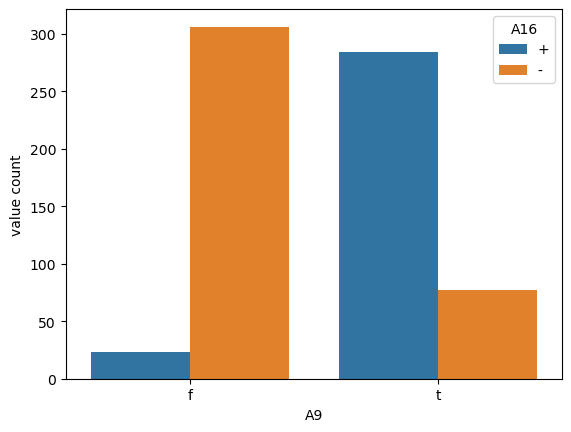

In [3]:
A9 = df[['A9','A16']]

ax = sns.barplot(
    data=A9.reset_index().groupby(['A9','A16']).count().reset_index(),
    x='A9',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [6]:
df.A9.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A10

[Text(0, 0.5, 'value count')]

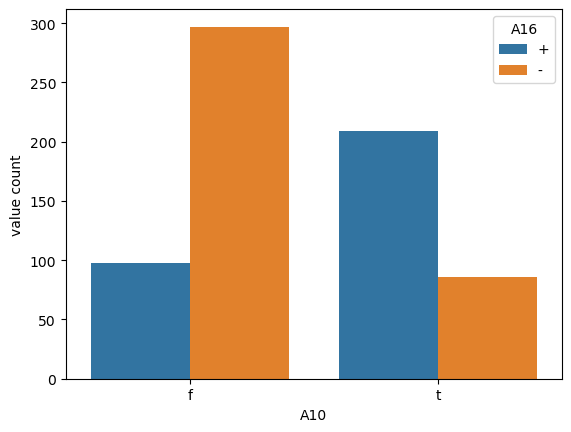

In [7]:
A10 = df[['A10','A16']]

ax = sns.barplot(
    data=A10.reset_index().groupby(['A10','A16']).count().reset_index(),
    x='A10',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [8]:
df.A10.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A11

<Axes: xlabel='A11', ylabel='Count'>

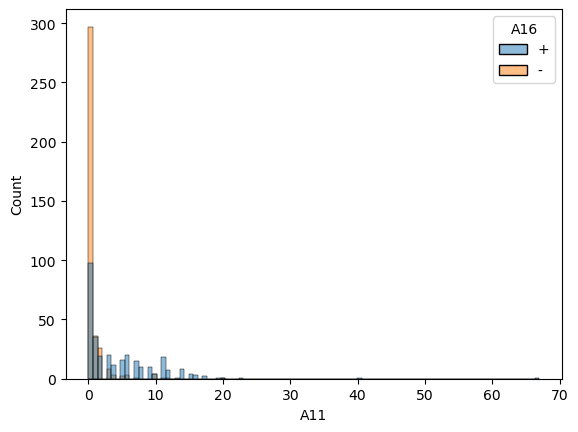

In [10]:
A11 = df[['A11','A16']]
sns.histplot(A11, x='A11', hue='A16')

Extremely strong left-skewed distribution with mostly Zeros. Apply a log1p transform.

<Axes: xlabel='A11', ylabel='Count'>

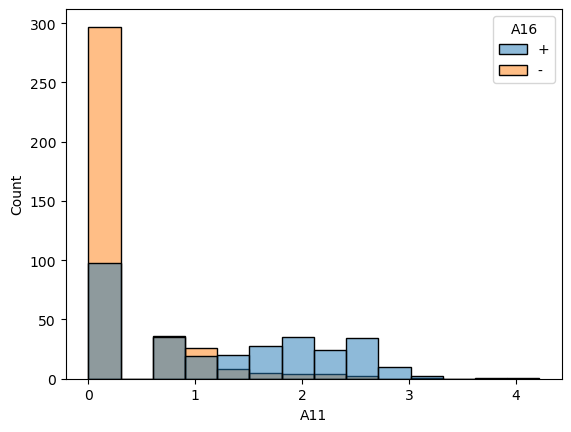

In [11]:
A11 = A11.assign(A11=A11.A11.apply(np.log1p))
sns.histplot(A11, x='A11', hue='A16')

This looks much better.

### A12

[Text(0, 0.5, 'value count')]

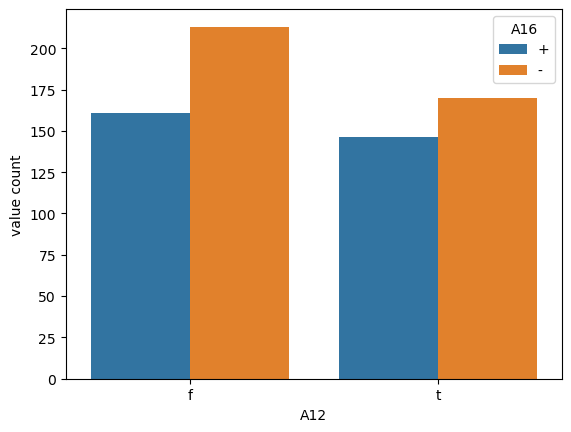

In [12]:
A12 = df[['A12','A16']]

ax = sns.barplot(
    data=A12.reset_index().groupby(['A12','A16']).count().reset_index(),
    x='A12',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

In [13]:
df.A12.isna().sum()

0

Feature is already in binary format and doesn't have any missing values. Perfect.

### A13

[Text(0, 0.5, 'value count')]

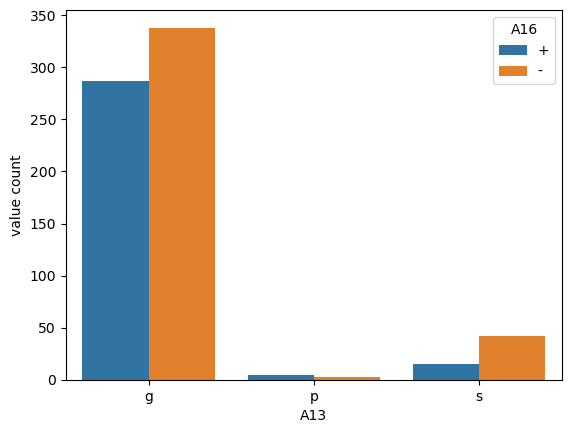

In [15]:
A13 = df[['A13','A16']]

ax = sns.barplot(
    data=A13.reset_index().groupby(['A13','A16']).count().reset_index(),
    x='A13',
    y='index',
    hue='A16')
ax.set(ylabel='value count')

Binarise. Since the distirbution of A16 among p resembles more that of g, summarise g and p into one category.

### A14

<Axes: xlabel='A14', ylabel='Count'>

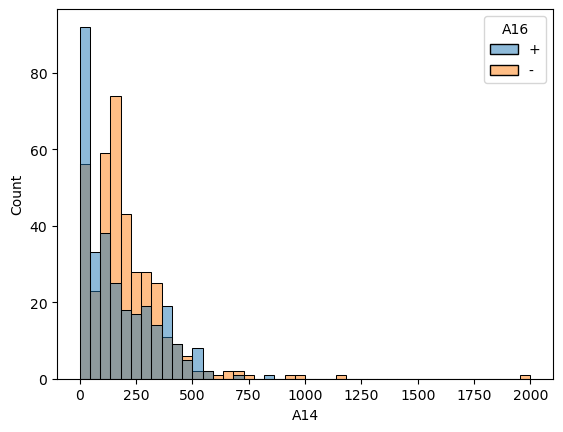

In [16]:
A14 = df[['A14','A16']]
sns.histplot(A14, x='A14', hue='A16')

Strongly left-skewed, apply log1p transform.

<Axes: xlabel='A14', ylabel='Count'>

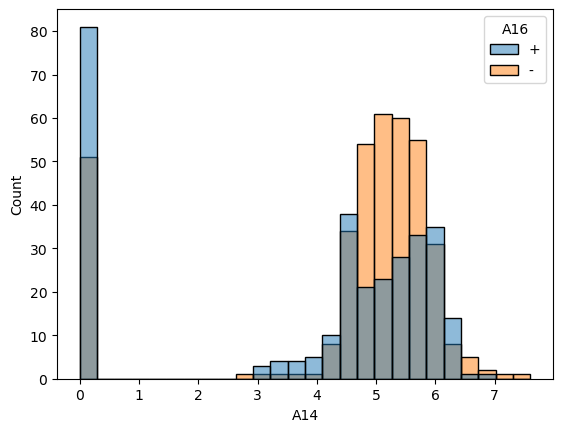

In [17]:
A14 = A14.assign(A14=A14.A14.apply(np.log1p))
sns.histplot(A14, x='A14', hue='A16')

Fine.

### A15

<Axes: xlabel='A15', ylabel='Count'>

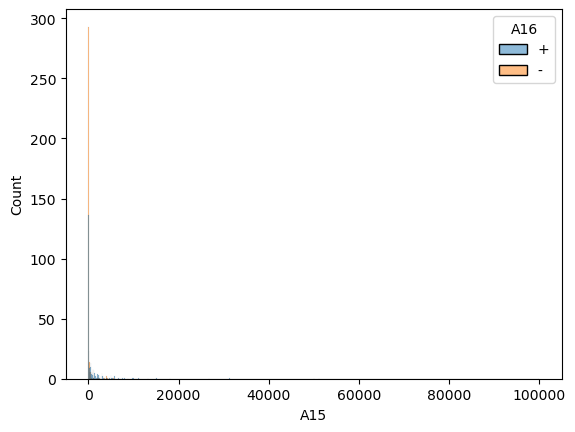

In [18]:
A15 = df[['A15','A16']]
sns.histplot(A15, x='A15', hue='A16')

Apply a log1p transform.

<Axes: xlabel='A15', ylabel='Count'>

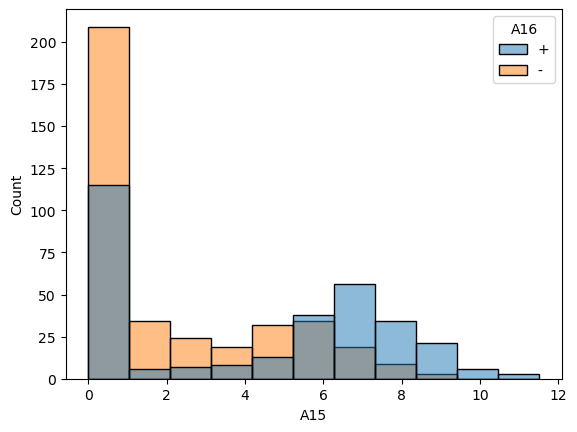

In [22]:
A15 = A15.assign(A15=A15.A15.apply(np.log1p))
sns.histplot(A15, x='A15', hue='A16')

Looks much better. Keep that.

### A16

In [23]:
df.A16.value_counts()

-    383
+    307
Name: A16, dtype: int64

## NaN Analysis

In [ ]:
credit_approval.variables[['name','missing_values']]

In [ ]:
df.isna().any(axis=1).sum()/df.shape[0]

About 5% of the data contains missing values.

TODO: look if some features are always NaN at the same time

## comments on variables

A3 let be

A4 binary, 6 missing values
summarize categories y and l to 'not-u' category, replace missing valuses with most frequent

A5 discarded, correlation of 1 with A4

A6 realtively uniformly disributed over 13 categories, not really sure what to do
maybe discard, because correlated by >.5 with A7
(maybe PCA with A7) (alternatively: frequency encode)

A7 9 categries
summarise to categories v, h, other. encode missing values as most frequent

A8 let be

A9 let be (note: highly correlated with target)

A10 let be

A11 log1p, replace with median

A12 let be

A13 summarise to g and not-g

A14 log1p, replace with median

A15 log1p, replace with median

A16 target, let be

mim-max scale all continuious variables
onehot encoder all categorical variables

## Correlations with target

Correlate every variables with target:
- categorical data: Cramers V
- continuous data: Point biserial correlation

### categorical

<Axes: >

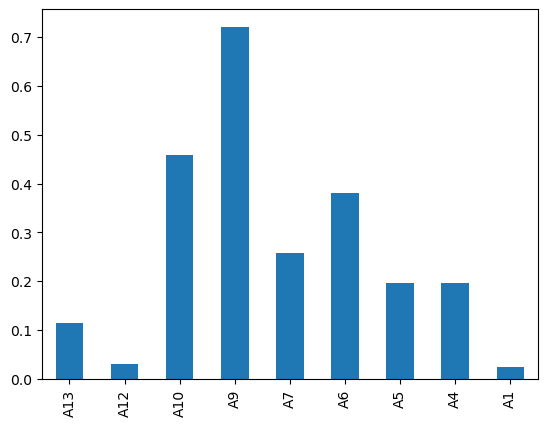

In [52]:
categorical_variables = credit_approval.variables[(credit_approval.variables.type == 'Categorical') & (credit_approval.variables.role == 'Feature')].name.values
s = pd.Series(index=categorical_variables)


for var in categorical_variables:
    s[var] = association(pd.crosstab(df[var], df.A16))

s.plot(kind='bar')

### continuous

<Axes: >

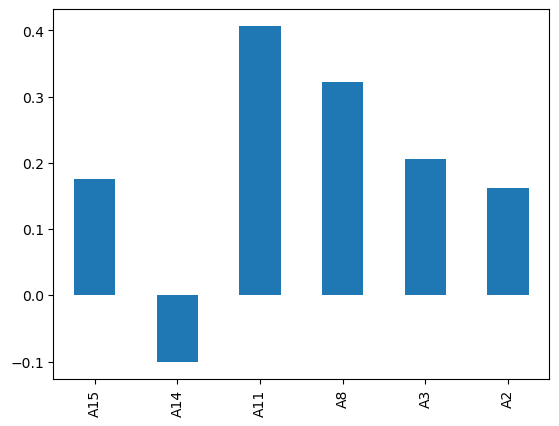

In [51]:
target = y.replace({'+':1,'-':0})

continuous_variables = credit_approval.variables[(credit_approval.variables.type == 'Continuous') & (credit_approval.variables.role == 'Feature')].name.values

s = pd.Series(index=continuous_variables)


for var in continuous_variables:
    s[var] = pointbiserialr(target[~df[var].isna()].values.ravel(), df[var].dropna().values).statistic

s.plot(kind='bar')

## Correlations and mutual information between variables

In [ ]:
"""
Compute mutual information in every commbination of two variables. We don't use product-momment or rank correlation since it assumes at least a monotonic relationship, which is a assumption we don't want to make at this point.

- Cramer's V for all combinations of categorical variables
- Pearson and Spearman for all combinations of continuous variables

- Mutal information for every combination of variables.

"""

In [42]:
category = credit_approval.variables[['name','type']].set_index('name')

### Between categorical variables
Cramer's V

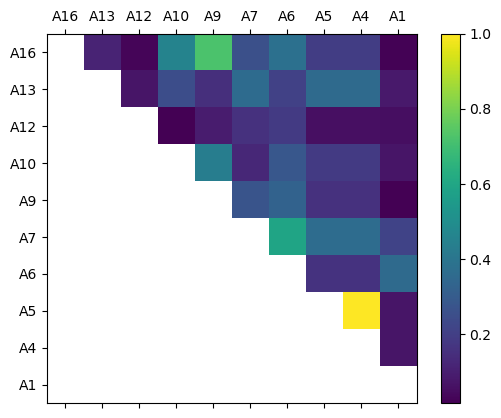

In [43]:
vars_cat    = category[category.type == 'Categorical'].index
n_cat       = len(vars_cat)
cramers_mat = pd.DataFrame(index=vars_cat, columns=vars_cat, dtype=np.float64)

for var1, var2 in itertools.combinations(vars_cat, r=2):
    cramers_mat.loc[var1,var2] = association(pd.crosstab(df[var1], df[var2]))

fig, ax = plt.subplots()
axi = ax.matshow(cramers_mat)
ax.set_xticks(range(n_cat), labels=vars_cat)
ax.set_yticks(range(n_cat), labels=vars_cat)

plt.colorbar(axi, ax=ax);

### Between continuous variables

In [ ]:
vars_con    = category[category.type == 'Continuous'].index
n_con       = len(vars_con)

pearson_mat = pd.DataFrame(index=vars_con, columns=vars_con, dtype=np.float64)
spearman_mat = pd.DataFrame(index=vars_con, columns=vars_con, dtype=np.float64)


#### Pearson product-moment correlation coefficient

In [ ]:
for var1, var2 in itertools.combinations(vars_con, r=2):
    
    pearson_mat.loc[var1,var2] =  pearsonr(
        df[[var1,var2]].dropna(how='any')[var1],
        df[[var1,var2]].dropna(how='any')[var2]).statistic

fig, ax = plt.subplots()
axi = ax.matshow(pearson_mat)
ax.set_xticks(range(n_con), labels=vars_con)
ax.set_yticks(range(n_con), labels=vars_con)

plt.colorbar(axi, ax=ax);

#### Spearman rank correlation coefficient

In [ ]:
for var1, var2 in itertools.combinations(vars_con, r=2):
    
    spearman_mat.loc[var1,var2] =  spearmanr(
        df[[var1,var2]].dropna(how='any')[var1],
        df[[var1,var2]].dropna(how='any')[var2]).statistic

fig, ax = plt.subplots()
axi = ax.matshow(spearman_mat)
ax.set_xticks(range(n_con), labels=vars_con)
ax.set_yticks(range(n_con), labels=vars_con)

plt.colorbar(axi, ax=ax);

### Mutual information (combinations of categorical and continuous)

In this context, there is no reasonable way known to the authers to correlate a multi-class (k > 2) categorical variable to a continuous variable.

- Therefore, we already do some tweaking of the data here, applying reasonable ways to allow us to correlate as many features as possible. Namely: Make A4, A5 and A13 binary variables by by summarising classes.

- Also, we apply the log transform to features with a strongly skewed distribution (A3, A8, A11, A14, A15) already, to make the correlations more meaningfull, since we are not (!) doing rank correlations.

- A obvious way to deal with A6 and A7 is target encoding, we will also already apply that here, for the sake of not leaving A6 and A7 completely out of the feature-feature correlations. This is however still EDA and not the feature engineering part.

- Since only 5% of the data contains missing values, we will for now throw out any column that has missing values.

In [44]:
column_tweaker = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='first'),
        ['A1','A9','A10','A12','A16']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['u'])),
        ['A4']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['g'])),
        ['A5']
    ),
    (
        # becoming numeric column
        TargetEncoder(),
        ['A6', 'A7']
    ),
    (
        FunctionTransformer(lambda col: label_binarize(col, classes=['g'])),
        ['A13']
    ),
    (
        FunctionTransformer(np.log1p),
        ['A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='passthrough'
)

df_tweaked = df.copy(deep=True).dropna(how='any')
var_names = df.columns

df_tweaked = pd.DataFrame(column_tweaker.fit_transform(df_tweaked, y=df_tweaked.A16), columns=['A1','A9','A10','A12' ,'A16','A4','A5','A6','A7','A13','A3','A8','A11','A14','A15','A2'])
df_tweaked = df_tweaked[var_names] # bring columns in right order again

category = credit_approval.variables[['name','type']].set_index('name')
category.loc[['A6','A7'],:] = 'Continuous'

df_tweaked.head(7)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1.0,30.83,0.000000,1.0,1.0,0.530921,0.589084,0.810930,1.0,1.0,0.693147,0.0,1.0,5.313206,0.000000,0.0
1,0.0,58.67,1.697449,1.0,1.0,0.366179,0.329138,1.396245,1.0,1.0,1.945910,0.0,1.0,3.784190,6.329721,0.0
2,0.0,24.50,0.405465,1.0,1.0,0.384612,0.344929,0.916291,1.0,0.0,0.000000,0.0,1.0,5.638355,6.715383,0.0
3,1.0,27.83,0.932164,1.0,1.0,0.491315,0.556974,1.558145,1.0,1.0,1.791759,1.0,1.0,4.615121,1.386294,0.0
4,1.0,20.17,1.890850,1.0,1.0,0.469734,0.559829,0.996949,1.0,0.0,0.000000,0.0,0.0,4.795791,0.000000,0.0
5,1.0,32.08,1.609438,1.0,1.0,0.651871,0.576173,1.252763,1.0,0.0,0.000000,1.0,1.0,5.888878,0.000000,0.0
6,1.0,33.17,0.712950,1.0,1.0,1.000000,0.406350,2.014903,1.0,0.0,0.000000,1.0,1.0,5.105945,10.350926,0.0


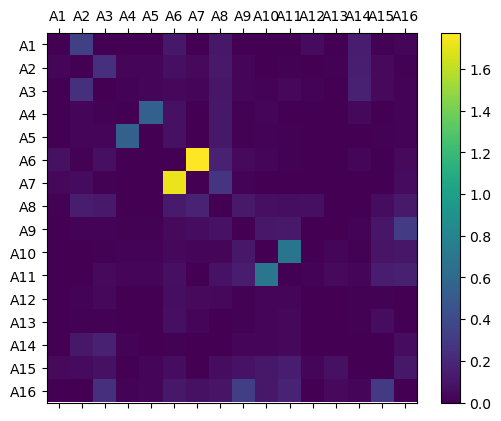

In [57]:
warnings.simplefilter('ignore', UserWarning)

mutual_informaion = pd.DataFrame(index=var_names, columns=var_names)

# each variable is taken as target variable
for var in var_names:
    
    discrete_features_mask = (category.loc[category.index!=var,:] == 'Categorical').values.ravel()
    
    # use mutual_info_regression if targeted variable is continuous
    if category.loc[var][0] == 'Continuous':
        mutual_informaion.loc[var, var_names != var] = mutual_info_regression(
            df_tweaked.loc[:, df_tweaked.columns != var],
            df_tweaked[var],
            discrete_features=discrete_features_mask
        )

    # use mutual_info_regression if targeted variable is categorical
    if category.loc[var][0] == 'Categorical':
        mutual_informaion.loc[var, var_names != var] = mutual_info_classif(
            df_tweaked.loc[:, df_tweaked.columns != var],
            df_tweaked[var],
            discrete_features=discrete_features_mask
        )
mutual_informaion = mutual_informaion.fillna(0)

fig, ax = plt.subplots()
axi = ax.matshow(mutual_informaion)
ax.set_xticks(range(len(var_names)), labels=var_names)
ax.set_yticks(range(len(var_names)), labels=var_names)

plt.colorbar(axi, ax=ax);

## Conclusions

In [55]:
cramers_mat.loc['A7','A6']

0.5896455216352515

In [58]:
mutual_informaion.loc['A7','A6']

1.723153208774066

How to deal with A7 ?

A categorical feature with 9 categories. Target encoding didn't bring very promising univariate results even after summarizing from 9 to 3 categories.


However, we also found A7 to only have a medium correlation with the target variable in comparison to the other features and shares a relatively high ammount of mutual information with A6.

Therefore it seems like a reasonable option either just keep the not very promising looking target encoding, as to only add one dimension through this feature, or leave it out all together (which feature selection should do automaticly if our univariate observations also apply in combination with the other features).

## Principal component analysis

In [64]:
df_tweaked

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1.0,30.83,0.000000,1.0,1.0,0.530921,0.589084,0.810930,1.0,1.0,0.693147,0.0,1.0,5.313206,0.000000,0.0
1,0.0,58.67,1.697449,1.0,1.0,0.366179,0.329138,1.396245,1.0,1.0,1.945910,0.0,1.0,3.784190,6.329721,0.0
2,0.0,24.50,0.405465,1.0,1.0,0.384612,0.344929,0.916291,1.0,0.0,0.000000,0.0,1.0,5.638355,6.715383,0.0
3,1.0,27.83,0.932164,1.0,1.0,0.491315,0.556974,1.558145,1.0,1.0,1.791759,1.0,1.0,4.615121,1.386294,0.0
4,1.0,20.17,1.890850,1.0,1.0,0.469734,0.559829,0.996949,1.0,0.0,0.000000,0.0,0.0,4.795791,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1.0,21.08,2.405593,0.0,0.0,0.419109,0.348992,0.810930,0.0,0.0,0.000000,0.0,1.0,5.564520,0.000000,1.0
649,0.0,22.67,0.559616,1.0,1.0,0.543711,0.589084,1.098612,0.0,1.0,1.098612,1.0,1.0,5.303305,5.978886,1.0
650,0.0,25.25,2.674149,0.0,0.0,0.868071,0.877612,1.098612,0.0,1.0,0.693147,1.0,1.0,5.303305,0.693147,1.0
651,1.0,17.92,0.186480,1.0,1.0,0.598743,0.576173,0.039221,0.0,0.0,0.000000,0.0,1.0,5.638355,6.621406,1.0


In [94]:
X_tweaked = df_tweaked.iloc[:,:15]
y_tweaked = pd.DataFrame(df_tweaked.A16)

In [101]:
X_tweaked_train, X_tweaked_test, y_tweaked_train, y_tweaked_test = train_test_split(X_tweaked, y_tweaked, test_size=.1)

In [204]:
pca = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=2,svd_solver='full')
)
pca

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=2, svd_solver='full'))])

In [212]:
df_a7=df_tweaked.loc[:,df_tweaked.columns!='A7']
df_a7

,A1,A2,A3,A4,A5,A6,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1.0,30.83,0.000000,1.0,1.0,0.530921,0.810930,1.0,1.0,0.693147,0.0,1.0,5.313206,0.000000,0.0
1,0.0,58.67,1.697449,1.0,1.0,0.366179,1.396245,1.0,1.0,1.945910,0.0,1.0,3.784190,6.329721,0.0
2,0.0,24.50,0.405465,1.0,1.0,0.384612,0.916291,1.0,0.0,0.000000,0.0,1.0,5.638355,6.715383,0.0
3,1.0,27.83,0.932164,1.0,1.0,0.491315,1.558145,1.0,1.0,1.791759,1.0,1.0,4.615121,1.386294,0.0
4,1.0,20.17,1.890850,1.0,1.0,0.469734,0.996949,1.0,0.0,0.000000,0.0,0.0,4.795791,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1.0,21.08,2.405593,0.0,0.0,0.419109,0.810930,0.0,0.0,0.000000,0.0,1.0,5.564520,0.000000,1.0
649,0.0,22.67,0.559616,1.0,1.0,0.543711,1.098612,0.0,1.0,1.098612,1.0,1.0,5.303305,5.978886,1.0
650,0.0,25.25,2.674149,0.0,0.0,0.868071,1.098612,0.0,1.0,0.693147,1.0,1.0,5.303305,0.693147,1.0
651,1.0,17.92,0.186480,1.0,1.0,0.598743,0.039221,0.0,0.0,0.000000,0.0,1.0,5.638355,6.621406,1.0


In [214]:
res = pd.DataFrame(pca.fit_transform(df_a7), columns = ['x','y'])
res.shape

(653, 2)

<Axes: xlabel='x', ylabel='y'>

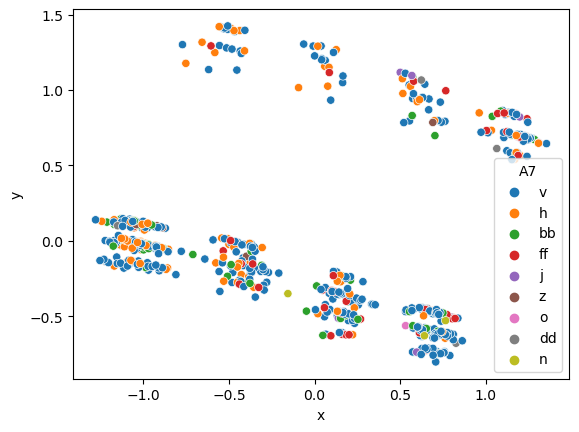

In [219]:
sns.scatterplot(res, x='x', y='y', hue=df.A7)

<BarContainer object of 10 artists>

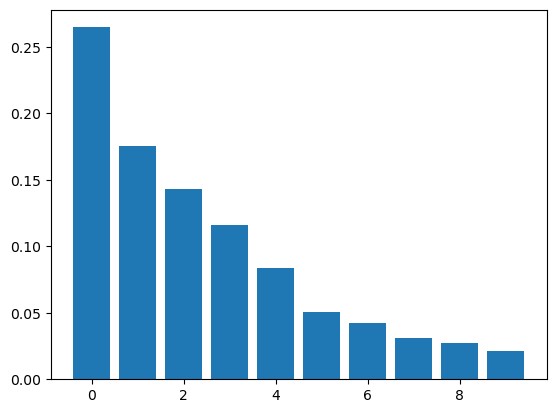

In [202]:
res = pca.fit(X_tweaked).transform(X_tweaked)

plt.bar(range(len(pca['pca'].explained_variance_ratio_)), pca['pca'].explained_variance_ratio_)

In [195]:
res

array([[-0.57454812, -0.02244739,  0.29928413, ...,  0.14973198,
        -0.03465061, -0.03832747],
       [-0.9629606 ,  0.04162606,  0.6955985 , ...,  0.26714029,
         0.3088212 ,  0.12146648],
       [-0.19110171, -0.37589765,  0.48509164, ...,  0.06033369,
        -0.06628271,  0.09134354],
       ...,
       [ 0.4834885 ,  0.90638566,  0.04074214, ...,  0.05510744,
        -0.18447237, -0.16065171],
       [ 0.4730976 , -0.70864263,  0.2157968 , ..., -0.01770741,
        -0.09791562,  0.00348397],
       [ 0.28736204, -0.47582014, -0.72217146, ...,  0.10226178,
        -0.18762124,  0.10391519]])

In [190]:
res = pd.DataFrame(res, columns = ['x','y'])
res.shape

(653, 2)

<Axes: xlabel='x', ylabel='y'>

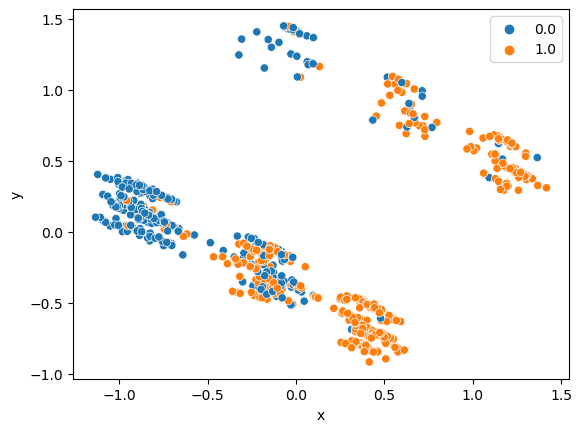

In [191]:
sns.scatterplot(res, x='x', y='y', hue=y_tweaked.values.ravel())